In [1]:
import pysal as ps
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import shapely.geometry as geom
import seaborn.apionly as sns
import numpy as np
%matplotlib inline

/home/lw17329/anaconda/envs/ana/lib/python3.5/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [2]:
data = pd.read_csv(ps.examples.get_path('GData_utm.csv'))
data['geometry'] = [geom.Point(x,y) for x,y in data[['X','Y']].values]
data = gpd.GeoDataFrame(data)

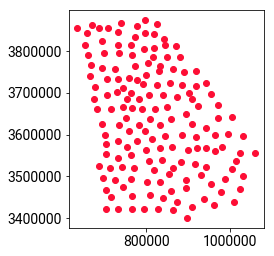

In [3]:
data.plot()

In [4]:
data.head()

,AreaKey,Latitude,Longitud,TotPop90,PctRural,PctBach,PctEld,PctFB,PctPov,PctBlack,ID,X,Y,geometry
0,13001,31.75339,-82.28558,15744,75.6,8.2,11.43,0.64,19.9,20.76,133,941396.6,3521764.0,POINT (941396.6 3521764)
1,13003,31.29486,-82.87474,6213,100.0,6.4,11.77,1.58,26.0,26.86,158,895553.0,3471916.0,POINT (895553 3471916)
2,13005,31.55678,-82.45115,9566,61.7,6.6,11.11,0.27,24.1,15.42,146,930946.4,3502787.0,POINT (930946.4 3502787)
3,13007,31.33084,-84.45401,3615,100.0,9.4,13.17,0.11,24.8,51.67,155,745398.6,3474765.0,POINT (745398.6 3474765)
4,13009,33.07193,-83.25085,39530,42.7,13.3,8.64,1.43,17.5,42.39,79,849431.3,3665553.0,POINT (849431.3 3665553)


In [5]:
X = data[['PctFB', 'PctPov', 'PctBlack']].values
Y = data[['PctBach']].values
coords = data[['X','Y']].values

In [6]:
N = Y.shape[0]

In [7]:
import imp
import mgwr
imp.reload(mgwr)

<module 'mgwr' from '/home/lw17329/Dropbox/dev/gwr/mgwr/__init__.py'>

In [8]:
sb = mgwr.sel_bw.Sel_BW(coords, Y, X, multi=True, fixed=True)
out = sb.search(search='scipy', tol=1e-2)

 48%|████▊     | 97/200 [05:10<05:29,  3.20s/it]

In [9]:
sb.search

'scipy'

In [10]:
from collections import namedtuple

In [11]:
partials = sb.bw.partial_models_

In [12]:
test = partials[0]

In [13]:
hats = [m.S for m in partials]

In [14]:
sb.bw.partial_predictions.shape

(159, 4)

In [15]:
fullmod = mgwr.gwr.MGWR(coords, Y, X, out, sb.bw.partial_predictions, sb.bw.model_residuals_).fit()

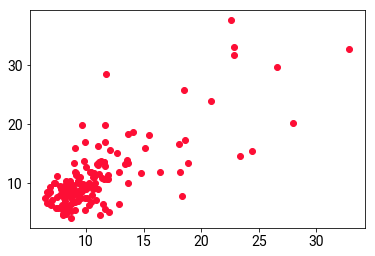

In [16]:
plt.scatter(fullmod.predy.sum(axis=1), Y)

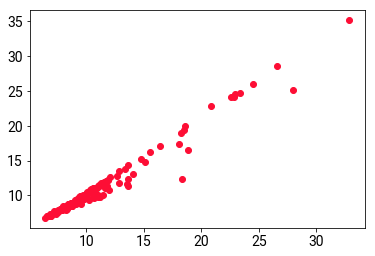

In [17]:
plt.scatter(fullmod.predy.flatten(), fullmod.model.XB.sum(axis=1))

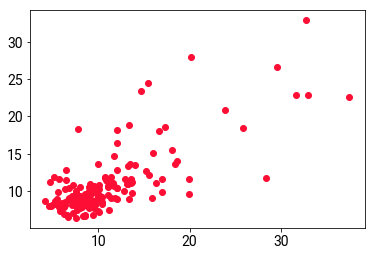

In [18]:
plt.scatter(Y, fullmod.predy.flatten())

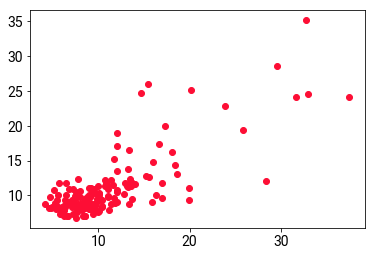

In [19]:
plt.scatter(Y, fullmod.model.XB.sum(axis=1))

(array([  1.,   0.,   0.,   1.,   3.,   8.,  22., 111.,   8.,   5.]),
 array([-5.91453093, -5.09364162, -4.27275231, -3.451863  , -2.63097369,
        -1.81008438, -0.98919507, -0.16830576,  0.65258355,  1.47347286,
         2.29436217]),
 <a list of 10 Patch objects>)

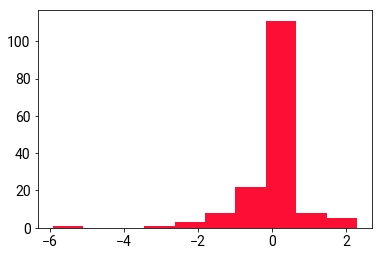

In [20]:
plt.hist(fullmod.model.XB.sum(axis=1) - fullmod.predy.flatten())

In [21]:
import scipy.linalg as scla

In [93]:
hats = [m.S for m in fullmod.model.models]
resids = np.vstack([m.resid_response for m in fullmod.model.models]).T

In [100]:
partial_sums = np.vstack([np.delete(resids, i, axis=1).sum(axis=1) for i in range(resids.shape[1])]).T

In [84]:
test = fullmod.model.models[0]

In [112]:
full_S = np.zeros((N,N))
In = np.eye(N)
Xc = np.hstack((np.ones_like(Y), X))
XBfinal = Xc * fullmod.params
outs = []
for i,S in enumerate(hats):
    outs.append(S.dot(Y - partial_sums[:,i].reshape(-1,1)))

In [78]:
full_S = np.zeros((N,N))
Yi = Y/scla.norm(Y)
In = np.eye(N)
Xc = np.hstack((np.ones_like(Y), X))
XBfinal = Xc * fullmod.params
for i,S in enumerate(hats):
    partial_prediction = XBfinal[:,i]
    other_partial_predictions = np.delete(XBfinal.copy(), i, axis=1)
    sum_smooths_notj = other_partial_predictions.sum(axis=1).reshape(-1,1)
    contribution = S - S.dot(sum_smooths_notj*Yi)
    full_S += contribution

In [82]:
S - S.dot(sum_smooths_notj * Yi.T)

array([[-0.23547867, -0.18206638, -0.18977909, ..., -0.29895659,
        -0.25056738, -0.17931646],
       [-0.29946308, -0.23108195, -0.24124034, ..., -0.38131366,
        -0.31902609, -0.227077  ],
       [-0.17403517, -0.13446435, -0.14024052, ..., -0.22119849,
        -0.18529201, -0.13235877],
       ...,
       [-0.57419052, -0.44844146, -0.46296288, ..., -0.70912319,
        -0.60242697, -0.44093733],
       [-0.48304757, -0.37579771, -0.38941698, ..., -0.60575178,
        -0.50733731, -0.36858272],
       [-0.33244098, -0.2563666 , -0.26766657, ..., -0.42358667,
        -0.35337764, -0.25044472]])

(array([8.0000e+00, 2.2000e+01, 1.8500e+02, 3.3310e+03, 2.0379e+04,
        1.2390e+03, 1.0000e+02, 1.5000e+01, 1.0000e+00, 1.0000e+00]),
 array([-2.65253985e+15, -2.04252447e+15, -1.43250908e+15, -8.22493702e+14,
        -2.12478320e+14,  3.97537062e+14,  1.00755244e+15,  1.61756783e+15,
         2.22758321e+15,  2.83759859e+15,  3.44761397e+15]),
 <a list of 10 Patch objects>)

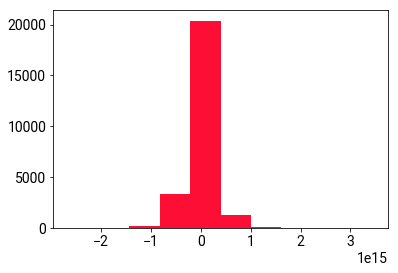

In [79]:
plt.hist(np.linalg.inv(full_S).flatten())

In [39]:
(XBfinal).sum(axis=1).reshape(-1,1) - fullmod.predy

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],